### VaR Comparison

In [87]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns


#### Declaring classes

##### Portofolio Class

In [88]:

class PortofolioData:
    def __init__(self, stocks, weights, Time, initial_investment, forecast_start_date=dt.datetime.now()):
        self.stocks = stocks
        self.weights = np.array(weights)
        self.Time = Time  # number of days over which the var is calculated
        self.initial_investment = initial_investment
        self.returns, self.mean_returns, self.cov_matrix = self.get_data(
                start_date=forecast_start_date-dt.timedelta(days=800), end_date=forecast_start_date)

    def get_data(
        self,
        start_date=dt.datetime.now() - dt.timedelta(days=800),
        end_date=dt.datetime.now(),
    ):
        # Get historical data and calculate returns
        stock_data = yf.download(self.stocks, start=start_date, end=end_date)

        stock_data = stock_data["Close"]
        returns = stock_data.pct_change()
        mean_returns = returns.mean()
        cov_matrix = returns.cov()
        returns = returns.dropna()
        returns["portofolio"] = returns.dot(self.weights)
        return returns, mean_returns, cov_matrix

    def get_expected_portofolio_performance(self):
        expected_returns = np.sum(self.mean_returns * self.weights) * self.Time
        expected_std = np.sqrt(
            np.dot(self.weights.T, np.dot(self.cov_matrix, self.weights))
        ) * np.sqrt(self.Time)
        return expected_returns, expected_std

    def __str__(self):
        txt = ""
        txt += f"PORTOFOLIO: {self.initial_investment}\n"
        for i in range(len(self.stocks)):
            txt += f"{self.stocks[i]}:{self.weights[i]*100}%\n"
        txt += "--------------------------\n"
        txt += "Returns:\n"
        txt += f"{self.returns}\n"
        txt += "--------------------------\n"
        txt += "Mean Returns:\n"
        txt += f"{self.mean_returns}\n"
        txt += "--------------------------\n"
        txt += "Covariance Matrix\n"
        txt += f"{self.cov_matrix}\n"
        txt += "--------------------------\n"
        return txt


##### VaR Class

In [89]:

class VaR:
    def __init__(self, portofolio: PortofolioData, confidence_level=0.95):
        self.portofolio = portofolio
        self.confidence_level = confidence_level
        self.alpha = 1 - confidence_level

    def calculate_historical_var(self):
        h_var = -np.percentile(
            self.portofolio.returns["portofolio"], self.alpha * 100
        ) * np.sqrt(self.portofolio.Time)

        return {
            "relative": h_var,
            "absolute": self.portofolio.initial_investment * h_var,
        }

    def calculate_parametric_var(self):

        expected_portofolio_return, expected_portofolio_std = (
            self.portofolio.get_expected_portofolio_performance()
        )

        p_var = (
            norm.ppf(self.confidence_level) * expected_portofolio_std
            - expected_portofolio_return
        )

        return {
            "relative": p_var,
            "absolute": self.portofolio.initial_investment * p_var,
        }

    def calculate_monte_carlo_var(self, simulations=1000):

        mean_m = np.full(
            shape=(self.portofolio.Time, len(self.portofolio.weights)),
            fill_value=self.portofolio.mean_returns,
        )
        mean_m = mean_m.T

        portfolio_sims = np.full(
            shape=(self.portofolio.Time, simulations), fill_value=0.0
        )

        for m in range(0, simulations):
            Z = np.random.normal(
                size=(self.portofolio.Time, len(self.portofolio.weights))
            )
            L = np.linalg.cholesky(self.portofolio.cov_matrix)
            daily_returns = mean_m + np.inner(L, Z)
            portfolio_sims[:, m] = (
                np.cumprod(np.inner(self.portofolio.weights, daily_returns.T) + 1)
                * self.portofolio.initial_investment
            )

        portResults = pd.Series(portfolio_sims[-1, :])
        kept = np.percentile(portResults, self.alpha * 100)

        absolute_mc_var = self.portofolio.initial_investment - kept
        relative_mc_var = absolute_mc_var / self.portofolio.initial_investment

        return {
            "relative": relative_mc_var,
            "absolute": absolute_mc_var,
        }

    def __str__(self):
        historical_var = self.calculate_historical_var()
        parametric_var = self.calculate_parametric_var()
        monte_carlo_var = self.calculate_monte_carlo_var()

        txt = "Value at Risk (VaR) Analysis:\n"
        txt += f"Confidence Level: {self.confidence_level * 100}%\n"
        txt += f"Historical VaR: {historical_var}\n"
        txt += f"Parametric VaR: {parametric_var}\n"
        txt += f"Monte Carlo VaR: {monte_carlo_var}\n"
        return txt


##### Fetching test portofolios

In [90]:
from generate_random_portfolios import read_portfolios_from_json

test_portfolios = read_portfolios_from_json("random_portfolios.json")

#### Comparing the VaR methods

In [91]:
# Get returns for each portofolio
returns = []
portofolios = []

for test_portfolio in test_portfolios:
    portofolio = PortofolioData(
        stocks=test_portfolio["stocks_list"],
        weights=test_portfolio["stocks_weights"],
        Time=1,
        initial_investment=1000,
    )
    portofolios.append(portofolio)
    test_portfolio["start_date"] = dt.datetime.strptime(test_portfolio["start_date"], "%Y-%m-%d")

    ret, mean_ret, cov_matrix = portofolio.get_data(
        test_portfolio["start_date"], 
        test_portfolio["start_date"] + dt.timedelta(days=test_portfolio["time"])
    )

    returns.append(ret)


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%********

In [92]:

def show_portfolio_distribution(returns, quantile = 0.05):
    sns.histplot(returns, bins=50, kde=True)

    quantile_mark = returns.quantile(quantile)  
    plt.axvline(quantile_mark, color='red', linestyle='dashed', label=f'95% Quantile: {quantile_mark:.4f}')

    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Return Distribution')
    plt.legend()
    plt.show()

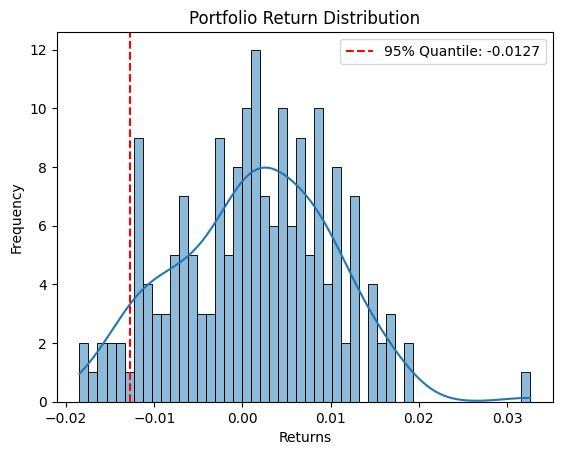

In [93]:
show_portfolio_distribution(returns[1]['portofolio'])

In [99]:
values_at_risk = []
for portofolio in portofolios:
    var = VaR(portofolio, confidence_level=0.95)
    values_at_risk.append(
        {
            "historical": -var.calculate_historical_var()['relative'],
            "parametric": -var.calculate_parametric_var()['relative'],
            "monte_carlo": -var.calculate_monte_carlo_var()['relative'],
        }
    )


In [100]:
values_at_risk

[{'historical': np.float64(-0.017079031631913027),
  'parametric': np.float64(-0.017756048223234372),
  'monte_carlo': np.float64(-0.018123736554101696)},
 {'historical': np.float64(-0.014939111282880857),
  'parametric': np.float64(-0.016392458865387816),
  'monte_carlo': np.float64(-0.016983588175029922)},
 {'historical': np.float64(-0.018750701301868854),
  'parametric': np.float64(-0.01852992311103773),
  'monte_carlo': np.float64(-0.01942775644435676)},
 {'historical': np.float64(-0.018933332911496462),
  'parametric': np.float64(-0.018881965458472726),
  'monte_carlo': np.float64(-0.019004930839254825)},
 {'historical': np.float64(-0.014565457999233077),
  'parametric': np.float64(-0.014550780245217746),
  'monte_carlo': np.float64(-0.01421544549971611)},
 {'historical': np.float64(-0.015993895519835523),
  'parametric': np.float64(-0.01668966397220728),
  'monte_carlo': np.float64(-0.015803402398069353)},
 {'historical': np.float64(-0.011887489375961124),
  'parametric': np.floa

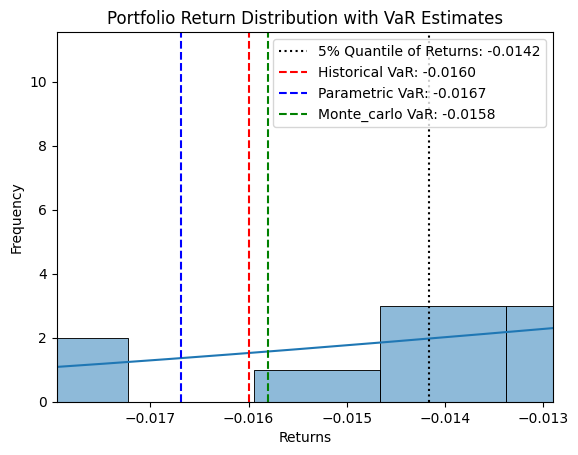

In [108]:


def show_portfolio_distribution_with_vars(returns, var_dict, quantile=0.05):
    # Plot the distribution with histogram and KDE
    sns.histplot(returns, bins=50, kde=True)
    
    # Plot the base quantile (for reference)
    base_quantile = returns.quantile(quantile)
    plt.axvline(base_quantile, color='black', linestyle='dotted', 
                label=f'{quantile*100:.0f}% Quantile of Returns: {base_quantile:.4f}')
    
    # Define a unique color for each VaR method
    colors = {
        "historical": "red",
        "parametric": "blue",
        "monte_carlo": "green"
    }
    
    # Plot a vertical line for each VaR method
    for method, var_value in var_dict.items():
        plt.axvline(var_value, color=colors.get(method, "gray"), linestyle='dashed', 
                    label=f'{method.capitalize()} VaR: {var_value:.4f}')
    
    # Determine the range to zoom in on the vertical lines
    # Get minimum and maximum of base quantile and all VaR values
    values = [base_quantile] + list(var_dict.values())
    min_val, max_val = min(values), max(values)
    
    # Calculate margin: you can adjust this multiplier to zoom in/out as desired
    margin = (max_val - min_val) * 0.5  
    plt.xlim(min_val - margin, max_val + margin)
    
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Return Distribution with VaR Estimates')
    plt.legend()
    plt.show()

# Example usage (ensure returns is a Series and values_at_risk is defined appropriately):
index = 5
show_portfolio_distribution_with_vars(returns[index]['portofolio'], values_at_risk[index], quantile=0.05)


### Custom VaR Model

In [94]:
import yfinance as yf
import pandas as pd

In [95]:
stock_data = yf.download('spx')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPX,SPX,SPX,SPX,SPX
Date,,,,,
2000-03-02,2.49834,2.49834,1.74884,1.74884,2562
2000-03-03,1.87375,1.87375,1.87375,1.87375,80
2000-03-06,2.49834,2.49834,2.49834,2.49834,240
2000-03-07,4.37209,4.37209,4.37209,4.37209,0
2000-03-08,4.37209,4.37209,4.37209,4.37209,0


In [96]:
stocks = ['SPX']
weights = [1]
Time = 30
initial_investment = 1000

portofolio = PortofolioData(stocks, weights,Time, initial_investment )

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SPX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2023-01-23 01:08:26.347071 -> 2025-04-02 01:08:26.347071)')
C:\Users\mario\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\mario\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\mario\AppData\Roaming\Python\Python313\site-packages\pandas\core\frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
C:\Users\mario\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\mario\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_